# Krigagem de temperatura, umidade e preciptação para todos os municípios de Minas Gerais no período de 2016 a 2018

O objetivo deste script é demonstrar o uso de krigagem oridinária em python usando o pacote pykrige. Os dados foram preparados previamente usando as informações coletadas pelas estações automáticas do INMET distribuídas por Minas Gerais. Assim, a krigagem nada mais é do que a interpolação espacial dos dados coletados pontualmente de forma a a ter os dados climáticos de todos os municípios mineiros.

Fonte de dados:
  - [Malha municupal do IBGE](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html)
  - Dados climáticos das estações automáticas do INMET - previamente agrupados com seus meta-dados em estacoes_mg
    - [Meta-dados das estações](https://portal.inmet.gov.br/paginas/catalogoaut)
    - [Dados históricos por estação](https://portal.inmet.gov.br/dadoshistoricos)

### Setup do ambiente

In [ ]:
!pip install pandas numpy geopandas geoplot matplotlib pykrige

  Using cached geoplot-0.5.1-py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 21.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

### Upload e tratamento das bases

In [ ]:
# Utilizando a malha de municipios mais recente do IBGE para MG
url_malha = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/MG/MG_Municipios_2022.zip"

!wget -O MG_Municipios_2023.zip $url_malha

--2025-02-28 17:12:57--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/MG/MG_Municipios_2022.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33017561 (31M) [application/zip]
Saving to: ‘MG_Municipios_2023.zip’

MG_Municipios_2023. 100%[===================>]  31.49M  12.7MB/s    in 2.5s    

2025-02-28 17:13:00 (12.7 MB/s) - ‘MG_Municipios_2023.zip’ saved [33017561/33017561]



In [ ]:
!unzip MG_Municipios_2023.zip -d "MG_Municipios_2023" # Descompactando a pasta com a malha municipal

Archive:  MG_Municipios_2023.zip
 extracting: MG_Municipios_2023/MG_Municipios_2022.cpg  
  inflating: MG_Municipios_2023/MG_Municipios_2022.dbf  
  inflating: MG_Municipios_2023/MG_Municipios_2022.prj  
  inflating: MG_Municipios_2023/MG_Municipios_2022.shp  
  inflating: MG_Municipios_2023/MG_Municipios_2022.shx  


In [ ]:
# Lendo shapefile
municipios = gpd.read_file('MG_Municipios_2023/MG_Municipios_2022.shp')

In [ ]:
# Utilizando os dados das estações previamente tratados
url_estacoes = "https://github.com/SofAguiar/krigagem_clima/raw/main/estacoes_mg.zip"

!wget -O estacoes_mg.zip $url_estacoes

--2025-02-28 17:35:51--  https://github.com/SofAguiar/krigagem_clima/raw/main/estacoes_mg.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/SofAguiar/krigagem_clima_mg/raw/main/estacoes_mg.zip [following]
--2025-02-28 17:35:51--  https://github.com/SofAguiar/krigagem_clima_mg/raw/main/estacoes_mg.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SofAguiar/krigagem_clima_mg/main/estacoes_mg.zip [following]
--2025-02-28 17:35:51--  https://raw.githubusercontent.com/SofAguiar/krigagem_clima_mg/main/estacoes_mg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected

In [ ]:
!unzip estacoes_mg.zip -d "estacoes_mg" # Descompactando a pasta com os dados das estações

Archive:  estacoes_mg.zip
replace estacoes_mg/estacoes_mg.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: estacoes_mg/estacoes_mg.csv  


In [ ]:
df_estacoes = pd.read_csv("estacoes_mg/estacoes_mg.csv")

In [ ]:
# Convertendo as colunas de data e variáveis para os tipos adequados
df_estacoes['Data'] = pd.to_datetime(df_estacoes['Data'], errors='coerce')
df_estacoes['temperatura_media'] = pd.to_numeric(df_estacoes['temperatura_media'], errors='coerce')
df_estacoes['preciptacao'] = pd.to_numeric(df_estacoes['preciptacao'], errors='coerce')
df_estacoes['umidade_media'] = pd.to_numeric(df_estacoes['umidade_media'], errors='coerce')
df_estacoes['VL_LATITUDE'] = pd.to_numeric(df_estacoes['VL_LATITUDE'], errors='coerce')
df_estacoes['VL_LONGITUDE'] = pd.to_numeric(df_estacoes['VL_LONGITUDE'], errors='coerce')
df_estacoes['NM_MUN'] = df_estacoes['cidade'].str.lower().str.strip()

municipios['NM_MUN'] = municipios['NM_MUN'].str.lower().str.strip()


In [ ]:
# Garantindo que o CRS seja WGS84 (EPSG:4326)
municipios = municipios.to_crs(epsg=4326)

# Calculando os centróides dos municípios para usá-los como pontos de interpolação
municipios['centroide'] = municipios.geometry.centroid
municipios['lon'] = municipios['centroide'].x
municipios['lat'] = municipios['centroide'].y

<ipython-input-53-d9cc5e62cc22>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipios['centroide'] = municipios.geometry.centroid


### Conferência e visualização da base

In [ ]:
df_dia = df_estacoes[df_estacoes['Data'] == np.datetime64('2016-01-01')]
print("Registros com temperatura:", df_dia['temperatura_media'].dropna().shape[0])
print("Registros com precipitação:", df_dia['preciptacao'].dropna().shape[0])
print("Registros com umidade:", df_dia['umidade_media'].dropna().shape[0])

Registros com temperatura: 53
Registros com precipitação: 56
Registros com umidade: 53


In [ ]:
df_dia = df_estacoes[df_estacoes['Data'] == np.datetime64('2018-12-31')]
print("Registros com temperatura:", df_dia['temperatura_media'].dropna().shape[0])
print("Registros com precipitação:", df_dia['preciptacao'].dropna().shape[0])
print("Registros com umidade:", df_dia['umidade_media'].dropna().shape[0])

Registros com temperatura: 66
Registros com precipitação: 67
Registros com umidade: 66


In [57]:
df_estacoes.head()

,Unnamed: 0,codigo,cidade,Data,preciptacao,pressao_atmosferica_media,temperatura_max,temperatura_min,temperatura_media,umidade_maxima,umidade_minima,umidade_media,VL_LATITUDE,VL_LONGITUDE,NM_MUN
0,1,A502,BARBACENA,2016-01-01,7.4,885.575000,30.3,18.5,23.241667,92.0,43.0,73.708333,-21.228333,-43.767778,barbacena
1,2,A502,BARBACENA,2016-01-02,8.6,885.975000,25.4,19.2,20.641667,94.0,72.0,88.916667,-21.228333,-43.767778,barbacena
2,3,A502,BARBACENA,2016-01-03,18.8,885.637500,25.6,18.2,20.366667,95.0,65.0,87.541667,-21.228333,-43.767778,barbacena
3,4,A502,BARBACENA,2016-01-04,24.0,887.458333,22.6,16.6,18.745833,95.0,68.0,87.333333,-21.228333,-43.767778,barbacena
4,5,A502,BARBACENA,2016-01-05,0.2,888.895833,24.3,13.6,18.375000,94.0,55.0,75.666667,-21.228333,-43.767778,barbacena


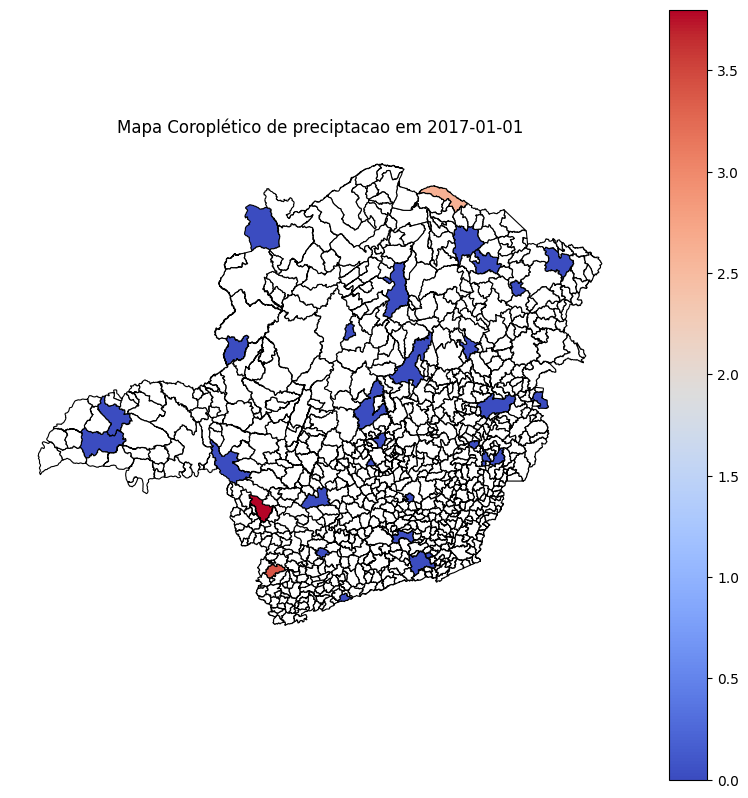

In [ ]:
variavel_climatica = "preciptacao"  # Uma variável de cada vez
data_especifica = "2017-01-01"  # Defina a data desejada

# Filtrar os dados para a data específica
df_estacoes_filtrado = df_estacoes[df_estacoes['Data'] == data_especifica].copy()

# Selecionar apenas colunas necessárias para evitar duplicação de colunas no merge
colunas_relevantes = ['NM_MUN', variavel_climatica]
df_estacoes_filtrado = df_estacoes_filtrado[colunas_relevantes]

# Unir os dados climáticos ao GeoDataFrame de municípios
municipios_filtrado = municipios.merge(df_estacoes_filtrado, on='NM_MUN', how='left', suffixes=('', '_estacao'))

# Criar a figura
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa coroplético
municipios_filtrado.plot(column=variavel_climatica, cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax, missing_kwds={"color": "white", "label": "Sem dados"})

# Ajustar título e remover eixos
ax.set_title(f"Mapa Coroplético de {variavel_climatica} em {data_especifica}", fontsize=12)
ax.set_axis_off()

# Exibir o mapa
plt.show()


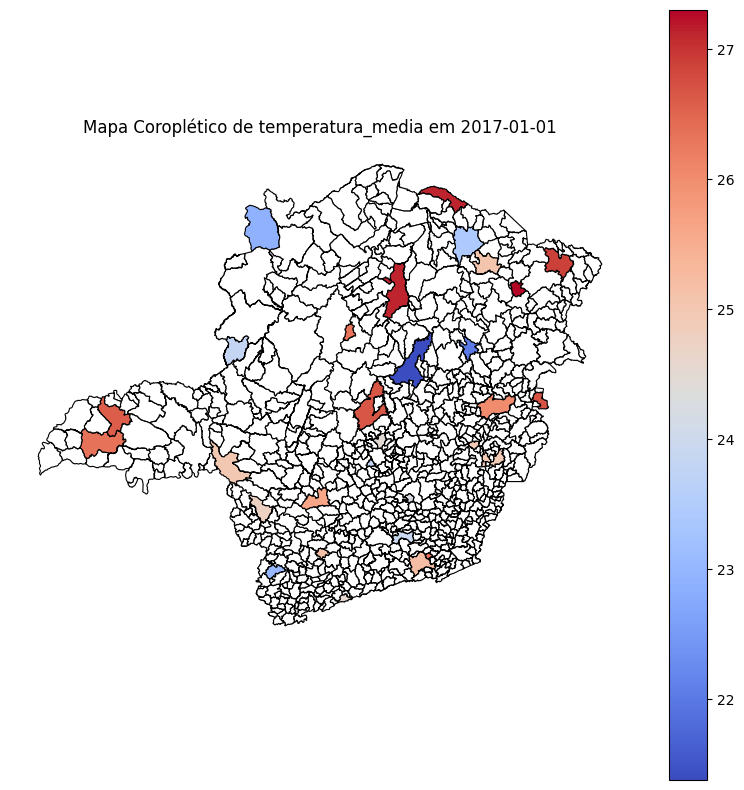

In [58]:
variavel_climatica = "temperatura_media"  # Uma variável de cada vez
data_especifica = "2017-01-01"  # Defina a data desejada

# Filtrar os dados para a data específica
df_estacoes_filtrado = df_estacoes[df_estacoes['Data'] == data_especifica].copy()

# Selecionar apenas colunas necessárias para evitar duplicação de colunas no merge
colunas_relevantes = ['NM_MUN', variavel_climatica]
df_estacoes_filtrado = df_estacoes_filtrado[colunas_relevantes]

# Unir os dados climáticos ao GeoDataFrame de municípios
municipios_filtrado = municipios.merge(df_estacoes_filtrado, on='NM_MUN', how='left', suffixes=('', '_estacao'))

# Criar a figura
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa coroplético
municipios_filtrado.plot(column=variavel_climatica, cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax, missing_kwds={"color": "white", "label": "Sem dados"})

# Ajustar título e remover eixos
ax.set_title(f"Mapa Coroplético de {variavel_climatica} em {data_especifica}", fontsize=12)
ax.set_axis_off()

# Exibir o mapa
plt.show()

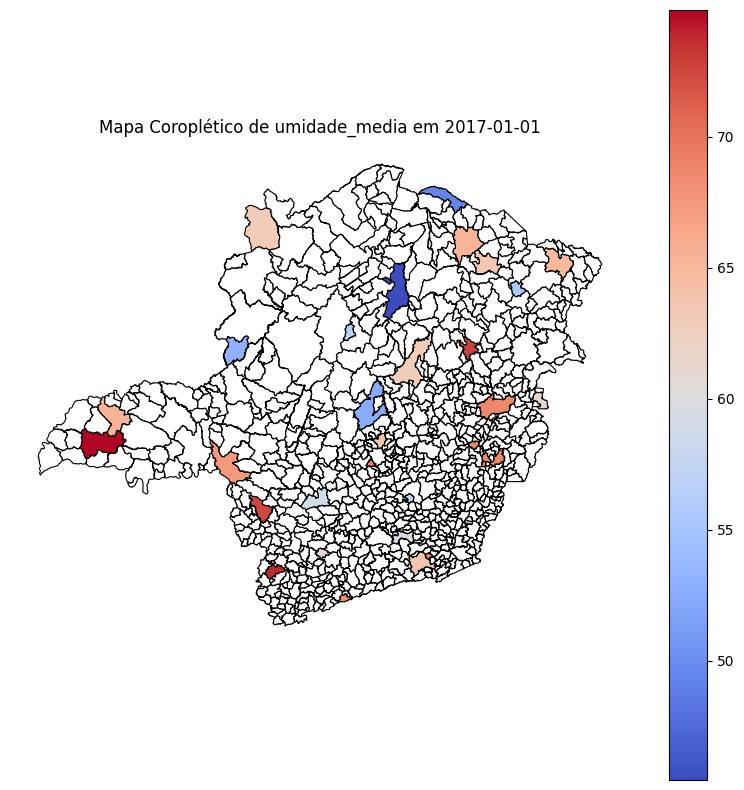

In [59]:
variavel_climatica = "umidade_media"  # Uma variável de cada vez
data_especifica = "2017-01-01"  # Defina a data desejada

# Filtrar os dados para a data específica
df_estacoes_filtrado = df_estacoes[df_estacoes['Data'] == data_especifica].copy()

# Selecionar apenas colunas necessárias para evitar duplicação de colunas no merge
colunas_relevantes = ['NM_MUN', variavel_climatica]
df_estacoes_filtrado = df_estacoes_filtrado[colunas_relevantes]

# Unir os dados climáticos ao GeoDataFrame de municípios
municipios_filtrado = municipios.merge(df_estacoes_filtrado, on='NM_MUN', how='left', suffixes=('', '_estacao'))

# Criar a figura
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa coroplético
municipios_filtrado.plot(column=variavel_climatica, cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax, missing_kwds={"color": "white", "label": "Sem dados"})

# Ajustar título e remover eixos
ax.set_title(f"Mapa Coroplético de {variavel_climatica} em {data_especifica}", fontsize=12)
ax.set_axis_off()

# Exibir o mapa
plt.show()

### Processo de krigagem

In [64]:
datas = np.sort(df_estacoes['Data'].dropna().unique())

# Lista para armazenar os resultados
resultados_lista = []

for data in datas:
    # Filtrar os dados do dia
    df_dia = df_estacoes[df_estacoes['Data'] == data]

    # -----------------------------
    # Krigagem para Temperatura Média
    # -----------------------------
    df_temp = df_dia.dropna(subset=['temperatura_media', 'VL_LATITUDE', 'VL_LONGITUDE'])
    if len(df_temp) >= 3:
        x_temp = df_temp['VL_LONGITUDE'].values
        y_temp = df_temp['VL_LATITUDE'].values
        z_temp = df_temp['temperatura_media'].values
        try:
            OK_temp = OrdinaryKriging(
                x_temp, y_temp, z_temp,
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False
            )
            z_temp_kriged, ss_temp = OK_temp.execute('points', municipios['lon'].values, municipios['lat'].values)
        except Exception as e:
            print(f"Erro na krigagem de temperatura em {data.date()}: {e}")
            z_temp_kriged = np.full(len(municipios), np.nan)
    else:
        z_temp_kriged = np.full(len(municipios), np.nan)

    # -----------------------------
    # Krigagem para Precipitação
    # -----------------------------
    df_prec = df_dia.dropna(subset=['preciptacao', 'VL_LATITUDE', 'VL_LONGITUDE'])
    if len(df_prec) >= 3:
        x_prec = df_prec['VL_LONGITUDE'].values
        y_prec = df_prec['VL_LATITUDE'].values
        z_prec = df_prec['preciptacao'].values
        try:
            # Se os valores forem constantes (sem variação), atribua o valor constante a todos os municípios
            if np.ptp(z_prec) == 0:
                z_prec_kriged = np.full(len(municipios), z_prec[0])
            else:
                OK_prec = OrdinaryKriging(
                    x_prec, y_prec, z_prec,
                    variogram_model='spherical',
                    verbose=False,
                    enable_plotting=False
                )
                z_prec_kriged, ss_prec = OK_prec.execute('points', municipios['lon'].values, municipios['lat'].values)
        except Exception as e:
            print(f"Erro na krigagem de precipitação em {pd.Timestamp(data).date()}: {e}")
            z_prec_kriged = np.full(len(municipios), np.nan)
    else:
        z_prec_kriged = np.full(len(municipios), np.nan)

    # -----------------------------
    # Krigagem para Umidade Média
    # -----------------------------
    df_umid = df_dia.dropna(subset=['umidade_media', 'VL_LATITUDE', 'VL_LONGITUDE'])
    if len(df_umid) >= 3:
        x_umid = df_umid['VL_LONGITUDE'].values
        y_umid = df_umid['VL_LATITUDE'].values
        z_umid = df_umid['umidade_media'].values
        try:
            OK_umid = OrdinaryKriging(
                x_umid, y_umid, z_umid,
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False
            )
            z_umid_kriged, ss_umid = OK_umid.execute('points', municipios['lon'].values, municipios['lat'].values)
        except Exception as e:
            print(f"Erro na krigagem de umidade em {data.date()}: {e}")
            z_umid_kriged = np.full(len(municipios), np.nan)
    else:
        z_umid_kriged = np.full(len(municipios), np.nan)

    # -----------------------------
    # 5. Criar um DataFrame com os resultados do dia
    # -----------------------------
    df_resultado_dia = pd.DataFrame({
        'Data': data,
        'CD_MUN': municipios['CD_MUN'],
        'Temperatura_Media': z_temp_kriged,
        'Preciptacao': z_prec_kriged,
        'Umidade_Media': z_umid_kriged
    })

    resultados_lista.append(df_resultado_dia)

final_df = pd.concat(resultados_lista, ignore_index=True)

### Verificação e visualização da interpolação

In [65]:
final_df.head()

,Data,CD_MUN,Temperatura_Media,Preciptacao,Umidade_Media
0,2016-01-01,3100104,24.814255,2.332133,71.214895
1,2016-01-01,3100203,26.327830,-0.439036,63.004710
2,2016-01-01,3100302,25.058005,1.346237,69.315929
3,2016-01-01,3100401,24.156653,4.334769,74.274005
4,2016-01-01,3100500,27.890152,-0.146384,62.068986


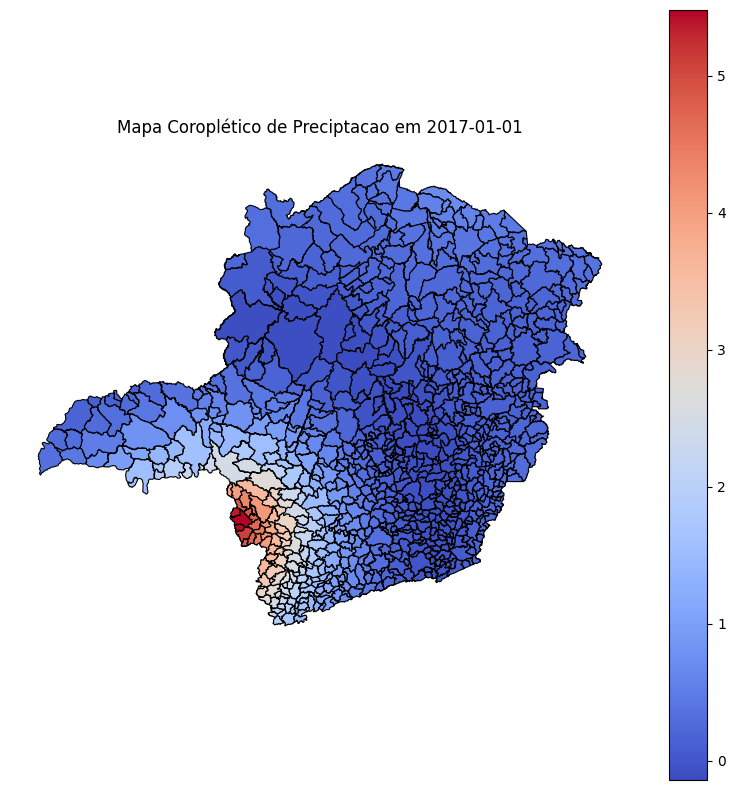

In [66]:
variavel_climatica = "Preciptacao"  # Uma variável de cada vez
data_especifica = "2017-01-01"  # Defina a data desejada

# Filtrar os dados para a data específica
final_df_filtrado = final_df[final_df['Data'] == data_especifica].copy()

# Selecionar apenas colunas necessárias para evitar duplicação de colunas no merge
colunas_relevantes = ['CD_MUN', variavel_climatica]
final_df_filtrado = final_df_filtrado[colunas_relevantes]

# Unir os dados climáticos ao GeoDataFrame de municípios
municipios_filtrado = municipios.merge(final_df_filtrado, on='CD_MUN', how='left', suffixes=('', '_estacao'))

# Criar a figura
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa coroplético
municipios_filtrado.plot(column=variavel_climatica, cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax, missing_kwds={"color": "white", "label": "Sem dados"})

# Ajustar título e remover eixos
ax.set_title(f"Mapa Coroplético de {variavel_climatica} em {data_especifica}", fontsize=12)
ax.set_axis_off()

# Exibir o mapa
plt.show()

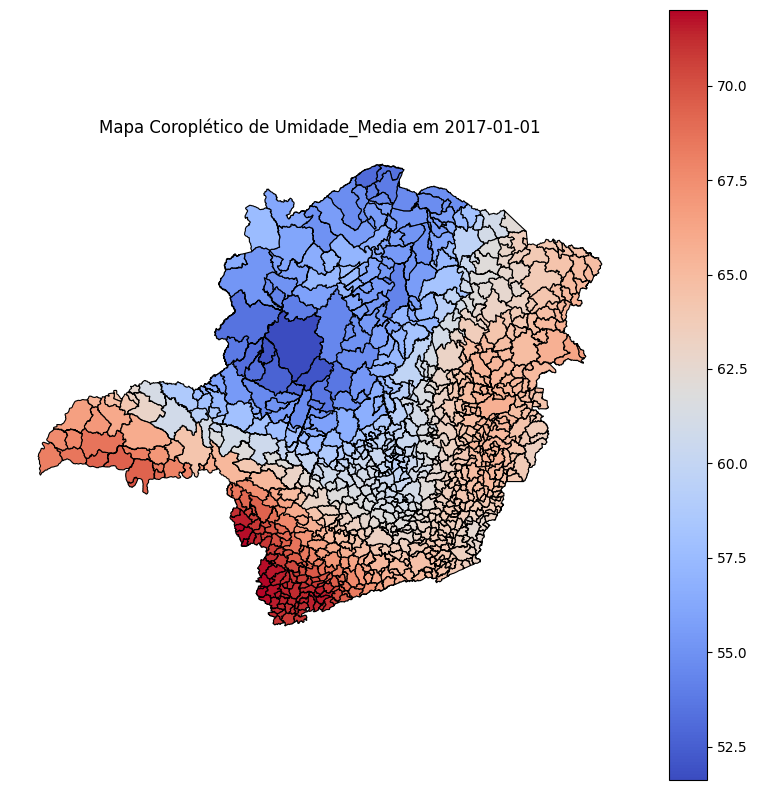

In [67]:
variavel_climatica = "Umidade_Media"  # Uma variável de cada vez
data_especifica = "2017-01-01"  # Defina a data desejada

# Filtrar os dados para a data específica
final_df_filtrado = final_df[final_df['Data'] == data_especifica].copy()

# Selecionar apenas colunas necessárias para evitar duplicação de colunas no merge
colunas_relevantes = ['CD_MUN', variavel_climatica]
final_df_filtrado = final_df_filtrado[colunas_relevantes]

# Unir os dados climáticos ao GeoDataFrame de municípios
municipios_filtrado = municipios.merge(final_df_filtrado, on='CD_MUN', how='left', suffixes=('', '_estacao'))

# Criar a figura
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa coroplético
municipios_filtrado.plot(column=variavel_climatica, cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax, missing_kwds={"color": "white", "label": "Sem dados"})

# Ajustar título e remover eixos
ax.set_title(f"Mapa Coroplético de {variavel_climatica} em {data_especifica}", fontsize=12)
ax.set_axis_off()

# Exibir o mapa
plt.show()

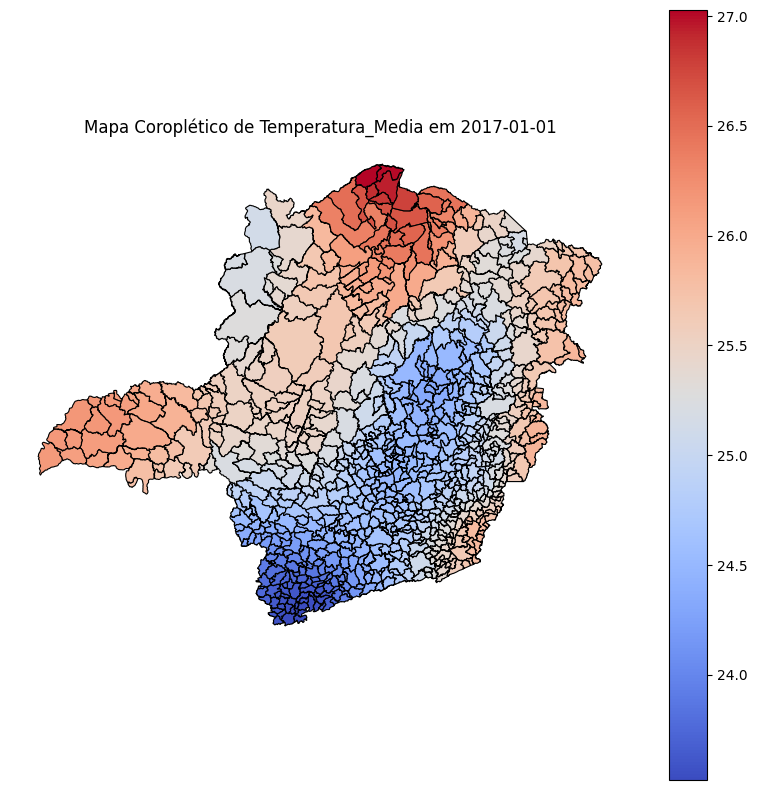

In [68]:
variavel_climatica = "Temperatura_Media"  # Uma variável de cada vez
data_especifica = "2017-01-01"  # Defina a data desejada

# Filtrar os dados para a data específica
final_df_filtrado = final_df[final_df['Data'] == data_especifica].copy()

# Selecionar apenas colunas necessárias para evitar duplicação de colunas no merge
colunas_relevantes = ['CD_MUN', variavel_climatica]
final_df_filtrado = final_df_filtrado[colunas_relevantes]

# Unir os dados climáticos ao GeoDataFrame de municípios
municipios_filtrado = municipios.merge(final_df_filtrado, on='CD_MUN', how='left', suffixes=('', '_estacao'))

# Criar a figura
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa coroplético
municipios_filtrado.plot(column=variavel_climatica, cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax, missing_kwds={"color": "white", "label": "Sem dados"})

# Ajustar título e remover eixos
ax.set_title(f"Mapa Coroplético de {variavel_climatica} em {data_especifica}", fontsize=12)
ax.set_axis_off()

# Exibir o mapa
plt.show()

### Exportação

In [ ]:
final_df.to_csv('resultado_krigagem_2016_2018.csv', index=False)

files.download('resultado_krigagem_2016_2018.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>